# Homework 7 (Gathering and Preparing Data for Visualization)


In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

### Problem 1 (2 points)

Write a Python script to download the HTML from https://en.wikipedia.org/wiki/2024_Summer_Olympics_medal_table

Read the olympic medals table into a Pandas dataframe from the HTML file and show the top ten rows

In [79]:
# Wikipedia URL for the 2024 Summer Olympics medal table
url = "https://en.wikipedia.org/wiki/2024_Summer_Olympics_medal_table"

# Read all tables from the Wikipedia page
tables = pd.read_html(url)

# The medal table is usually the first or second table, but this may change
# Let's inspect the first few tables and find the correct one
for i, table in enumerate(tables):
    print(f"Table {i}:\n", table.head(), "\n")

# Based on structure, select the correct table (manually check its index)
medal_table = tables[3]  # Update this index if necessary

# Display the top 10 rows
print(medal_table.head(10))

Table 0:
                          2024 Summer Olympics medals  \
0  Léon Marchand (pictured) won four gold medals ...   
1                                           Location   
2                                         Highlights   
3                                   Most gold medals   
4                                  Most total medals   

                       2024 Summer Olympics medals.1 Unnamed: 2  
0  Léon Marchand (pictured) won four gold medals ...        NaN  
1                                      Paris, France        NaN  
2                                         Highlights        NaN  
3                  China (40) and United States (40)        NaN  
4                                United States (126)        NaN   

Table 1:
           0                      1         2
0  ← 2020 ·  Olympics medal tables  · 2028 → 

Table 2:
                                                    0
0                                Part of a series on
1                               2024 

### Problem 2 (3 points)

Repeat the previous exercise with the 2020 Summer Olympics medal table, available at https://en.wikipedia.org/wiki/2020_Summer_Olympics_medal_table

**Combine** the 2024 and 2020 olympics tables into a single dataframe
* Keep a column for the country name (no need to keep the Rank column)
* **Add** medal counts together between years for the same country (add Gold to Gold, Silver to Silver, etc.)
* Check for duplicate country names that could have small variations in spelling / presentation between tables

Some things to be aware of
* Each table has a "Totals" row that should be removed
* Decorators like * and ‡ after country names may vary from year to year
* Any null values for medal counts can be replaced with 0

In [80]:
# URLs for the 2024 and 2020 Olympic medal tables
url_2024 = "https://en.wikipedia.org/wiki/2024_Summer_Olympics_medal_table"
url_2020 = "https://en.wikipedia.org/wiki/2020_Summer_Olympics_medal_table"

# Function to clean and format the medal table
def get_medal_table(url):
    tables = pd.read_html(url)

    # Identify the correct table (usually the first one, but check manually)
    medal_table = tables[3]

    # Rename columns to standardized names (based on the table's structure)
    medal_table.columns = ["Rank", "Country", "Gold", "Silver", "Bronze", "Total"]

    # Drop the "Rank" column (not needed)
    medal_table = medal_table.drop(columns=["Rank"])

    # Remove any "Totals" row
    medal_table = medal_table[medal_table["Country"] != "Totals"]

    # Clean up country names (remove * or ‡ symbols)
    medal_table["Country"] = medal_table["Country"].str.replace(r"[\*\‡]", "", regex=True).str.strip()

    # Convert medal count columns to numeric (handle possible NaNs)
    for col in ["Gold", "Silver", "Bronze", "Total"]:
        medal_table[col] = pd.to_numeric(medal_table[col], errors="coerce").fillna(0)

    return medal_table

# Fetch and clean both tables
df_2024 = get_medal_table(url_2024)
df_2020 = get_medal_table(url_2020)

# Merge both tables by country name, summing medal counts
df_combined = pd.merge(df_2024, df_2020, on="Country", how="outer", suffixes=("_2024", "_2020"))

# Fill any missing values with 0
df_combined = df_combined.fillna(0)

# Sum the medals across years
df_combined["Gold"] = df_combined["Gold_2024"] + df_combined["Gold_2020"]
df_combined["Silver"] = df_combined["Silver_2024"] + df_combined["Silver_2020"]
df_combined["Bronze"] = df_combined["Bronze_2024"] + df_combined["Bronze_2020"]
df_combined["Total"] = df_combined["Total_2024"] + df_combined["Total_2020"]

# Keep only relevant columns
df_combined = df_combined[["Country", "Gold", "Silver", "Bronze", "Total"]]

# Sort by total medals
df_combined = df_combined.sort_values(by="Total", ascending=False)

df_combined.head(10)

,Country,Gold,Silver,Bronze,Total
102,Totals (93 entries),340.0,338.0,402.0,1080.0
101,Totals (91 entries),329.0,330.0,385.0,1044.0
108,United States,79.0,85.0,75.0,239.0
19,China,78.0,59.0,43.0,180.0
39,Great Britain,36.0,42.0,51.0,129.0
54,Japan,47.0,26.0,30.0,103.0
4,Australia,35.0,26.0,38.0,99.0
35,France,26.0,38.0,33.0,97.0
51,Italy,22.0,23.0,35.0,80.0
83,ROC,20.0,28.0,23.0,71.0


### Problem 3 (3 points)

Continue the previous exercise, but download and join together all Summer Olympic medal tables from 2000 to 2024.
* Links to medal tables are available here:  https://en.wikipedia.org/wiki/Category:Summer_Olympics_medal_tables

Be mindful of slight variations from year to year, including things like
* Column names of tables
* Changes in country name (e.g. Russia to ROC)

In [81]:
# Function to generate Wikipedia URLs for Summer Olympics medal tables (2000-2024)
def generate_olympic_urls(start_year=2000, end_year=2024, interval=4):
    urls = {}
    for year in range(start_year, end_year + 1, interval):
        urls[year] = f"https://en.wikipedia.org/wiki/{year}_Summer_Olympics_medal_table"
    return urls

# Generate URLs dynamically
olympic_urls = generate_olympic_urls()

# Function to scrape, clean, and format a medal table from a given Wikipedia URL
def get_medal_table(url, year):
    tables = pd.read_html(url)

    # Identify the correct table (usually first, but may vary)
    medal_table = tables[3]

    # Standardize column names (handle slight variations in table structure over years)
    medal_table.columns = ["Rank", "Country", "Gold", "Silver", "Bronze", "Total"]

    # Drop Rank column
    medal_table = medal_table.drop(columns=["Rank"])

    # Remove "Totals" rows
    medal_table = medal_table[~medal_table["Country"].str.contains("Totals", na=False)]

    # Clean country names (remove * and special symbols)
    medal_table["Country"] = medal_table["Country"].apply(lambda x: re.sub(r"[\*\‡]", "", x).strip())

    # Convert medal counts to numeric, replacing NaNs with 0
    for col in ["Gold", "Silver", "Bronze", "Total"]:
        medal_table[col] = pd.to_numeric(medal_table[col], errors="coerce").fillna(0)

    # Add year column
    medal_table["Year"] = year

    return medal_table

# List to store all medal tables
all_medal_data = []

# Scrape medal tables for all years
for year, url in olympic_urls.items():
    try:
        df = get_medal_table(url, year)
        all_medal_data.append(df)
        print(f"Successfully scraped {year}")
    except Exception as e:
        print(f"Failed to scrape {year}: {e}")

# Combine all years into a single DataFrame
df_all_years = pd.concat(all_medal_data, ignore_index=True)

# Pivot the table to sum medals by country across all years
df_final = df_all_years.groupby("Country")[["Gold", "Silver", "Bronze", "Total"]].sum().reset_index()

# Sort by total medals
df_final = df_final.sort_values(by="Total", ascending=False)

df_final.head(10)

Successfully scraped 2000
Successfully scraped 2004
Successfully scraped 2008
Successfully scraped 2012
Successfully scraped 2016
Successfully scraped 2020
Successfully scraped 2024


,Country,Gold,Silver,Bronze,Total
130,United States,282,250,239,771
23,China,251,163,149,563
47,Great Britain,131,115,124,370
102,Russia,121,104,134,359
5,Australia,98,108,111,317
45,Germany,92,98,112,302
42,France,78,106,104,288
64,Japan,96,73,93,262
61,Italy,69,72,88,229
113,South Korea,71,58,65,194


### Problem 4 (2 points)

Using the data table created in problem 3, create two visualizations (following visualization best practices):
1. Display the top 5 countries by **total** medal count
2. Display the top 5 countries by **gold** medal count


<ipython-input-75-a6a4bc7a6138>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Country", y="Total", data=top5_total_medals, palette="Blues_d")


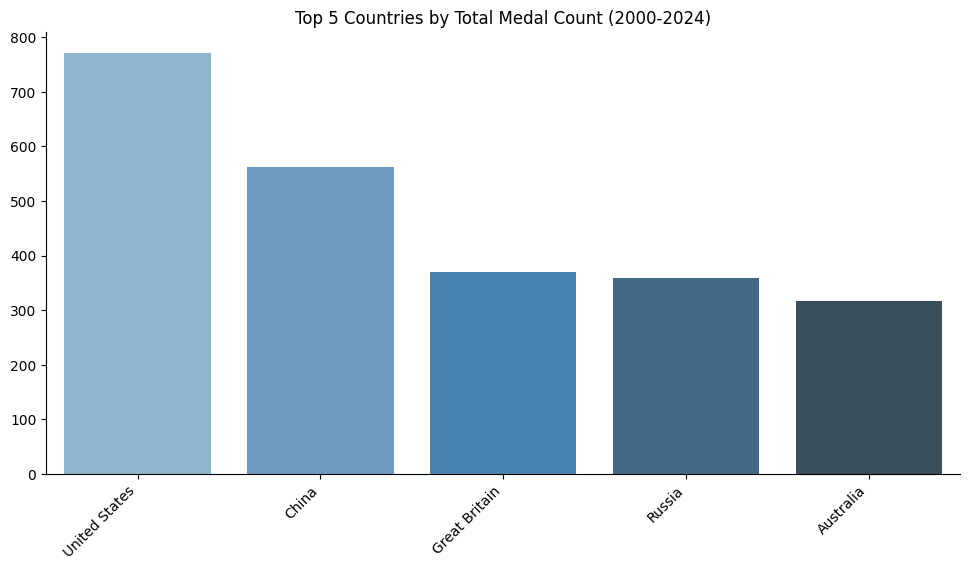

<ipython-input-75-a6a4bc7a6138>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Country", y="Gold", data=top5_gold_medals, palette="Oranges_d")


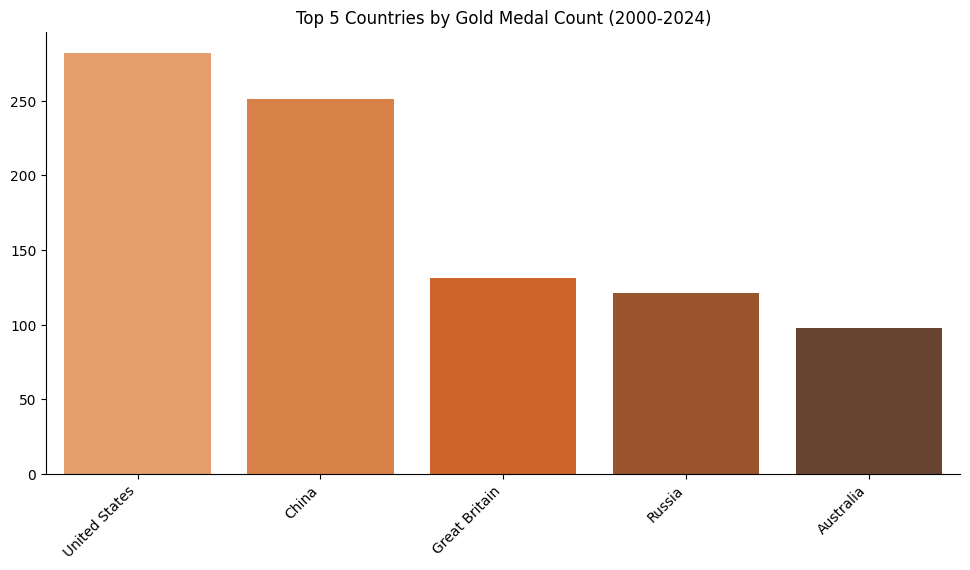

In [75]:
# Sort the DataFrame by total medals and get the top 5
top5_total_medals = df_final.sort_values(by="Total", ascending=False).head(5)

# Create a bar plot for total medals
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Country", y="Total", data=top5_total_medals, palette="Blues_d")
plt.title("Top 5 Countries by Total Medal Count (2000-2024)")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Hide top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove x and y labels
ax.set_xlabel("")
ax.set_ylabel("")

plt.show()

# Sort the DataFrame by gold medals and get the top 5
top5_gold_medals = df_final.sort_values(by="Gold", ascending=False).head(5)

# Create a bar plot for gold medals
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Country", y="Gold", data=top5_gold_medals, palette="Oranges_d")
plt.title("Top 5 Countries by Gold Medal Count (2000-2024)")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Hide top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove x and y labels
ax.set_xlabel("")
ax.set_ylabel("")

plt.show()

### Bonus Problem (2 points)

Using the data tables gathered from problems 1 to 3, create two additional visualizations (follwing best practices):
1. Show the trends in **total** medal count of the top 5 countries (problem 4 part 1) from 2000 to 2024
2. Show the trends in **gold** medal count of the top 5 countries (problem 4 part 2) from 2000 to 2024

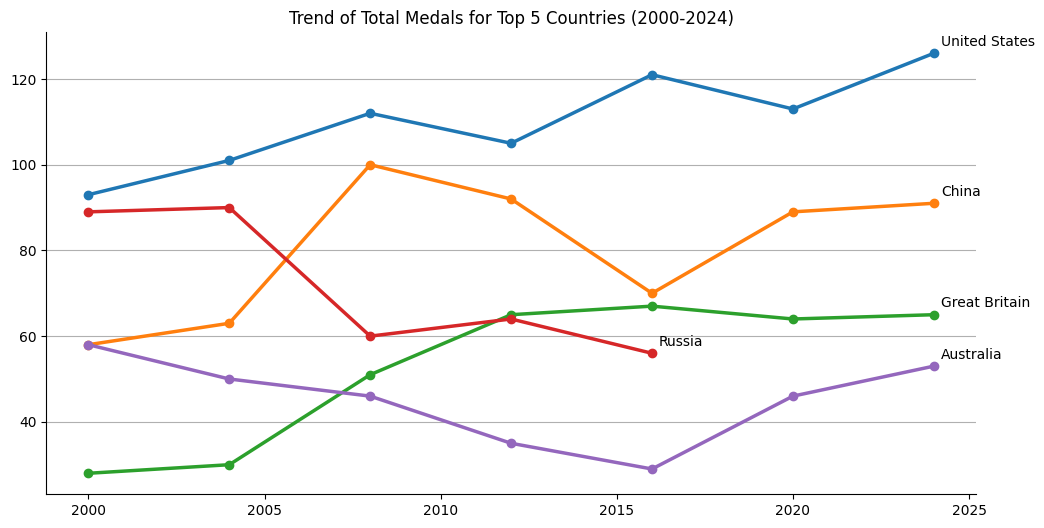

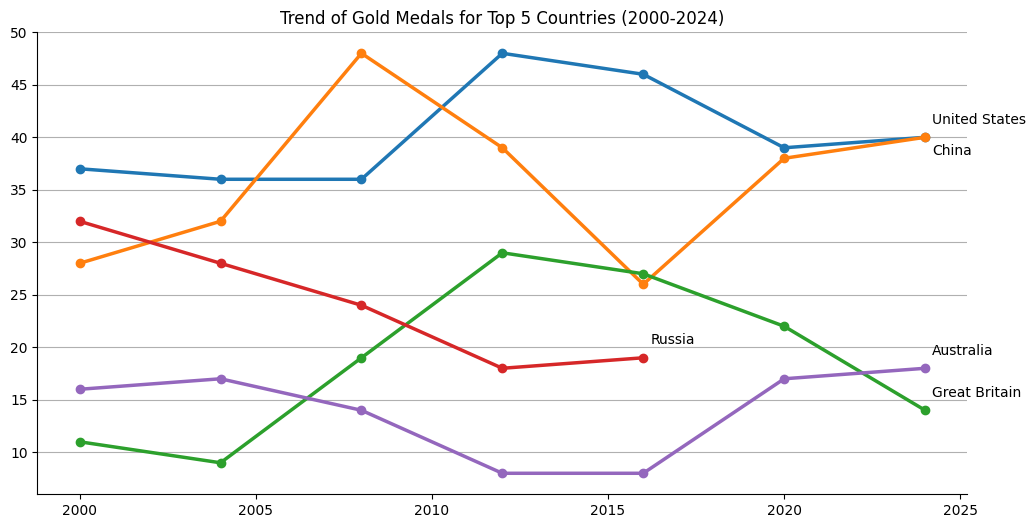

In [82]:
# Get top 5 countries by total medals and gold medals
top5_countries_total = df_final.nlargest(5, 'Total')['Country'].tolist()
top5_countries_gold = df_final.nlargest(5, 'Gold')['Country'].tolist()

# --- Total Medals Trend for Top 5 Countries ---
plt.figure(figsize=(12, 6))
ax = plt.gca()
for country in top5_countries_total:
    country_data = df_all_years[df_all_years['Country'] == country]
    plt.plot(country_data['Year'], country_data['Total'], label=country, linewidth=2.5, marker='o')
    x_pos = country_data['Year'].iloc[-1] + 0.2
    y_pos = country_data['Total'].iloc[-1] + 1
    plt.text(x_pos, y_pos, country, verticalalignment='bottom', horizontalalignment='left', fontsize=10)

plt.title("Trend of Total Medals for Top 5 Countries (2000-2024)")
plt.grid(axis='y')  # Remove vertical grid lines

# Remove top and left axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# --- Gold Medals Trend for Top 5 Countries ---
plt.figure(figsize=(12, 6))
ax = plt.gca()
for country in top5_countries_gold:
    country_data = df_all_years[df_all_years['Country'] == country]
    plt.plot(country_data['Year'], country_data['Gold'], label=country, linewidth=2.5, marker='o')
    x_pos = country_data['Year'].iloc[-1] + 0.2
    y_pos = country_data['Gold'].iloc[-1] + 1
    if country == "China":  # Hardcode China's label position
        y_pos += -3  # Adjust this value manually as needed
    plt.text(x_pos, y_pos, country, verticalalignment='bottom', horizontalalignment='left', fontsize=10)

plt.title("Trend of Gold Medals for Top 5 Countries (2000-2024)")
plt.grid(axis='y')  # Remove vertical grid lines

# Remove top and left axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()